# Import necessary libraries

In [93]:
!python -m pip install pandas numpy matplotlib seaborn scipy kneed scikit-learn

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [95]:
import seaborn as sns
import seaborn.objects as so
sns.set_theme(rc={
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"]
})

In [96]:
from scipy import stats
from scipy import interpolate

# Parse the data

In [97]:
STUDY = 'Study_Hours_Per_Day'
CLUBS = 'Extracurricular_Hours_Per_Day'
SLEEP = 'Sleep_Hours_Per_Day'
SOCIAL = 'Social_Hours_Per_Day'
PHYSICAL = 'Physical_Activity_Hours_Per_Day'
STRESS = 'Stress_Level'
GENDER = 'Gender'
GRADES = 'Grades'
STRESS_GROUPED = 'Stress_Grouped'

def humanize_column(column):
    output = ''
    for word in column.split('_'):
        output += (word + ' ')
    return output.rstrip()

def abbreviate_column(column):
    if column == STRESS_GROUPED:
        return 'Stress Grouped'
    else:
        words = column.split('_')
        if len(words) == 1:
            return words[0]
        else:
            return words[0] + ' ' + words[1]

In [98]:
# Parse Dataframe
df = pd.read_csv(
    "student_lifestyles.csv", index_col=0
)
df = df.astype(dtype={STRESS: 'category', GENDER: 'category'})
df[STRESS_GROUPED] = df[STRESS].map({
    "Low": "Low/Moderate",
    "Moderate": "Low/Moderate",
    "High": "High"
}).astype("category")
print(df.dtypes)

Study_Hours_Per_Day                 float64
Extracurricular_Hours_Per_Day       float64
Sleep_Hours_Per_Day                 float64
Social_Hours_Per_Day                float64
Physical_Activity_Hours_Per_Day     float64
Stress_Level                       category
Gender                             category
Grades                              float64
Stress_Grouped                     category
dtype: object


In [99]:
num_df = df.drop([GENDER, STRESS, STRESS_GROUPED], axis=1)

# Explore Correlated data

In [100]:
corr = num_df.corr(method='spearman')

<Axes: >

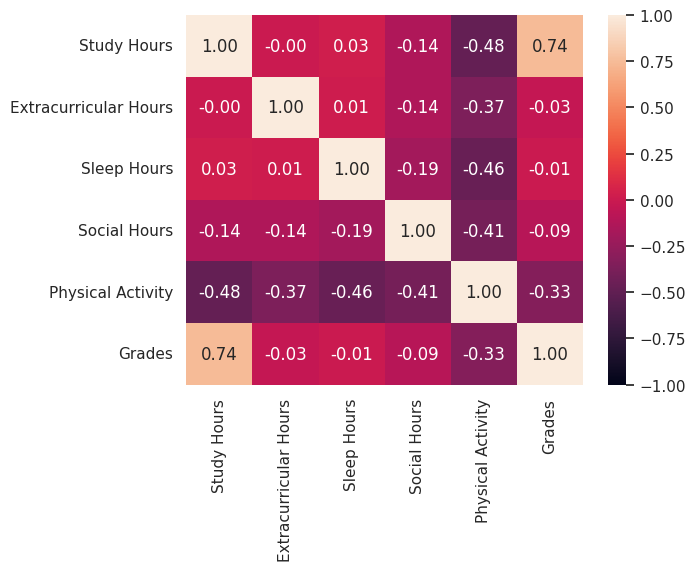

In [101]:
abbreviated_vars = [abbreviate_column(col) for col in corr.columns]
sns.heatmap(
    corr,
    cmap='rocket',
    annot=True,
#    mask=np.triu(np.ones_like(corr, dtype=bool)),
    fmt=".2f",
    vmin=-1, vmax=1,
    xticklabels=abbreviated_vars,
    yticklabels=abbreviated_vars
)

# High stress students display different patterns in data

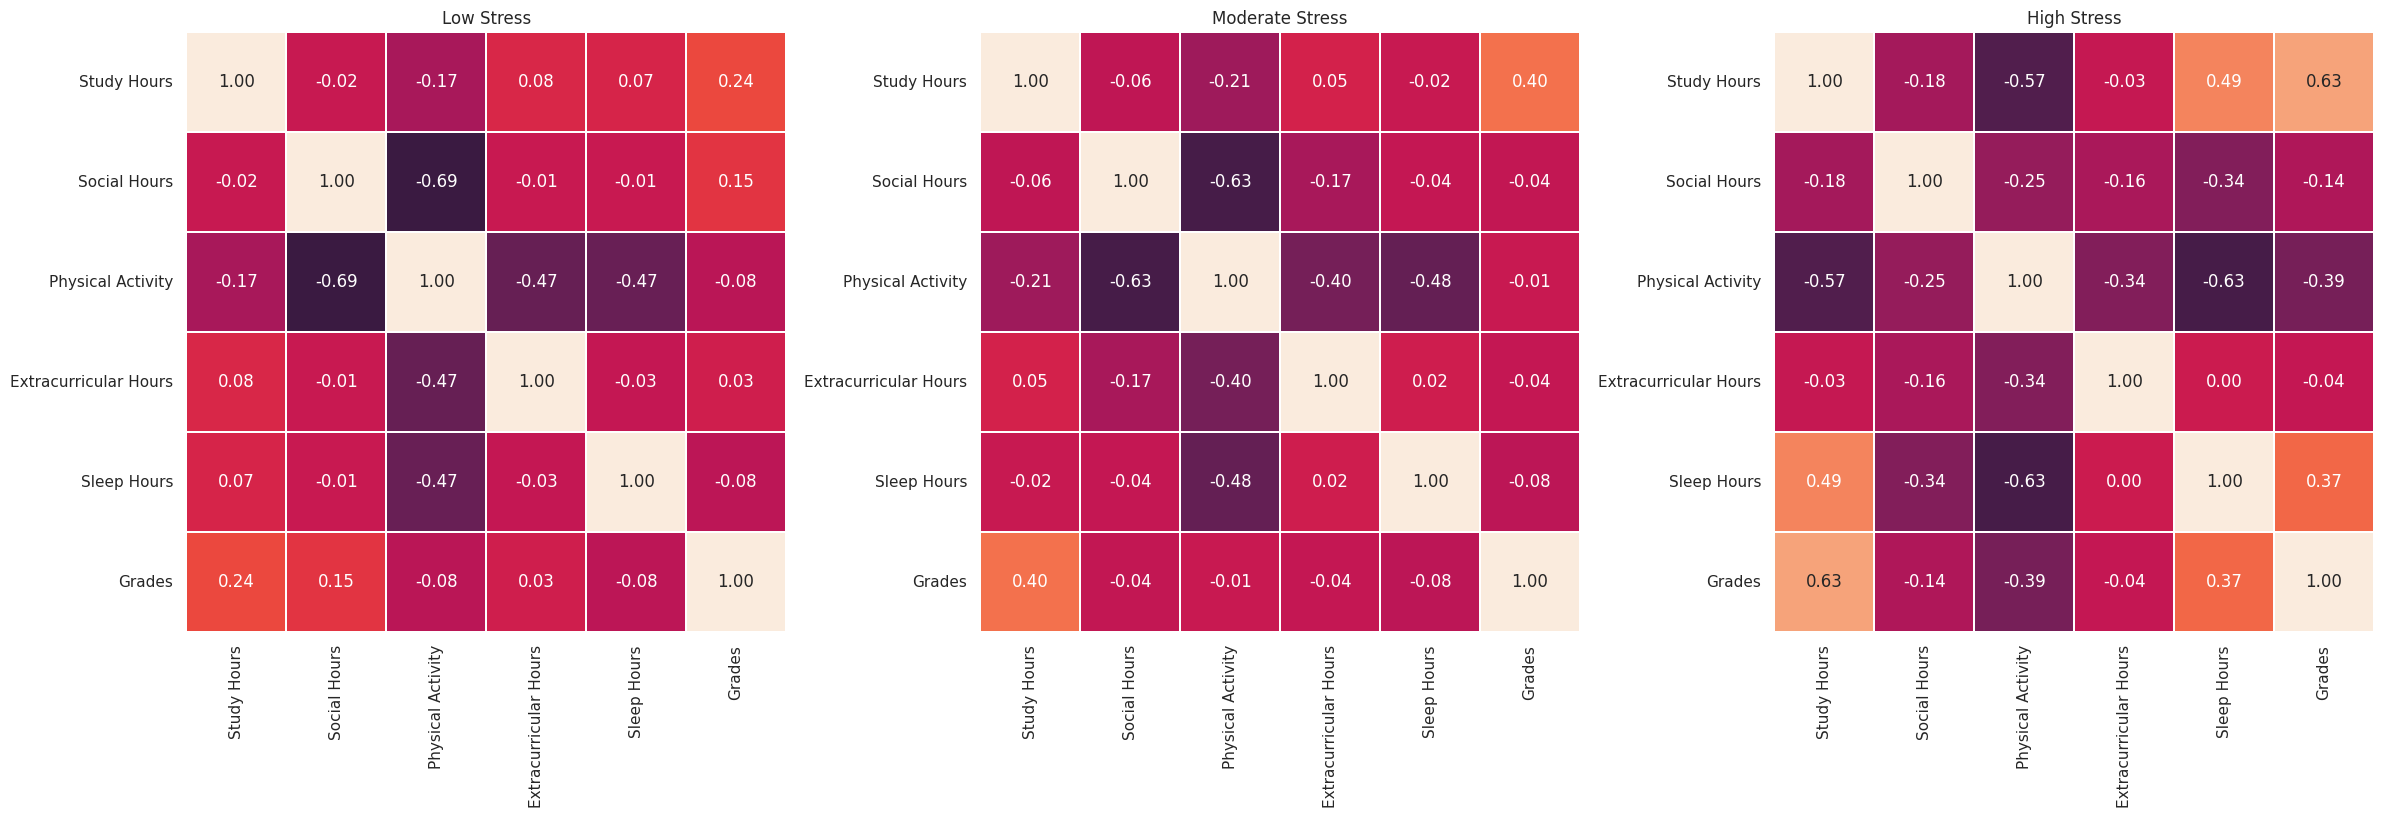

In [102]:
variables = [STUDY, SOCIAL, PHYSICAL, CLUBS, SLEEP, GRADES]
abbreviated_vars = [abbreviate_column(col) for col in variables]
stress_levels = ['Low', 'Moderate', 'High']
n = len(stress_levels)

fig, axes = plt.subplots(1, n, figsize=(8 * n, 8), squeeze=False)

for i, stress_level in enumerate(stress_levels):
    ax = axes[0, i]
    group = df[df[STRESS] == stress_level]
    corr = group[variables].corr(method='spearman')

    mask = np.triu(np.ones_like(corr, dtype=bool))

    sns.heatmap(
        corr,
        annot=True,
        fmt=".2f",
        cmap="rocket",
        vmin=-1, vmax=1,
        center=0,
#        mask=mask,
        linewidths=0.25,
        square=True,
        cbar=False,           # show colorbar on every heatmap
        ax=ax,
        xticklabels=abbreviated_vars,
        yticklabels=abbreviated_vars
    )
    ax.set_title(f"{stress_level} Stress")
    ax.set_aspect('equal', adjustable='box')  # keep aspect ratio equal

plt.tight_layout()
plt.show()

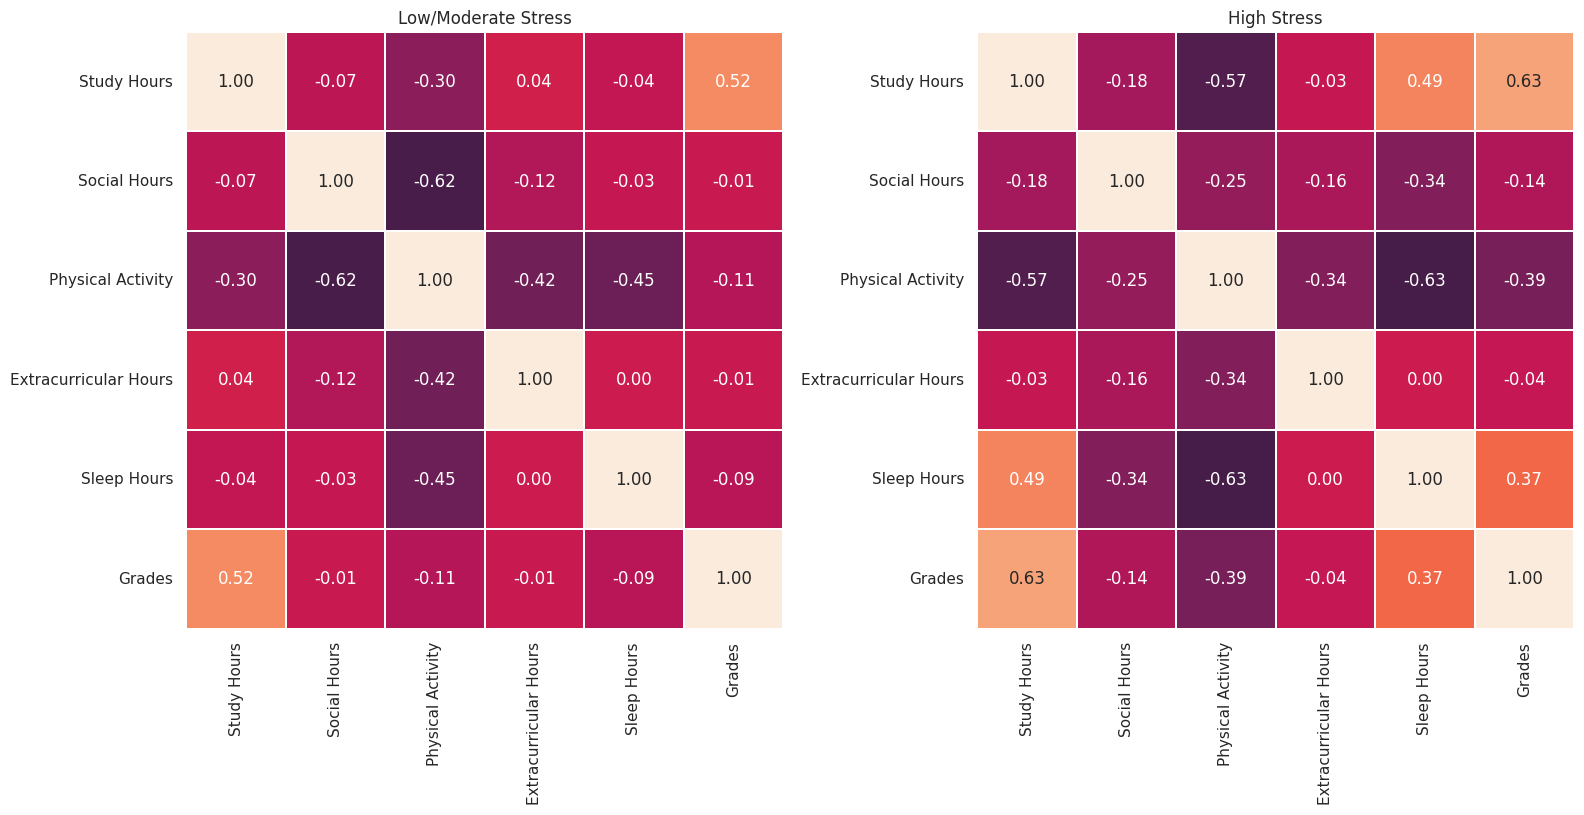

In [103]:
variables = [STUDY, SOCIAL, PHYSICAL, CLUBS, SLEEP, GRADES]
abberviated_vars = [abbreviate_column(col) for col in variables]
stress_levels = ['Low/Moderate', 'High']
n = len(stress_levels)

fig, axes = plt.subplots(1, n, figsize=(8 * n, 8), squeeze=False)

for i, stress_level in enumerate(stress_levels):
    ax = axes[0, i]
    group = df[df[STRESS_GROUPED] == stress_level]
    corr = group[variables].corr(method='spearman')

    mask = np.triu(np.ones_like(corr, dtype=bool))

    sns.heatmap(
        corr,
        annot=True,
        fmt=".2f",
        cmap="rocket",
        vmin=-1, vmax=1,
        center=0,
#       mask=mask,
        linewidths=0.25,
        square=True,
        cbar=False,           # show colorbar on every heatmap
        ax=ax,
        xticklabels=abberviated_vars,
        yticklabels=abberviated_vars
    )
    ax.set_title(f"{stress_level} Stress")
    ax.set_aspect('equal', adjustable='box')  # keep aspect ratio equal

plt.tight_layout()
plt.show()

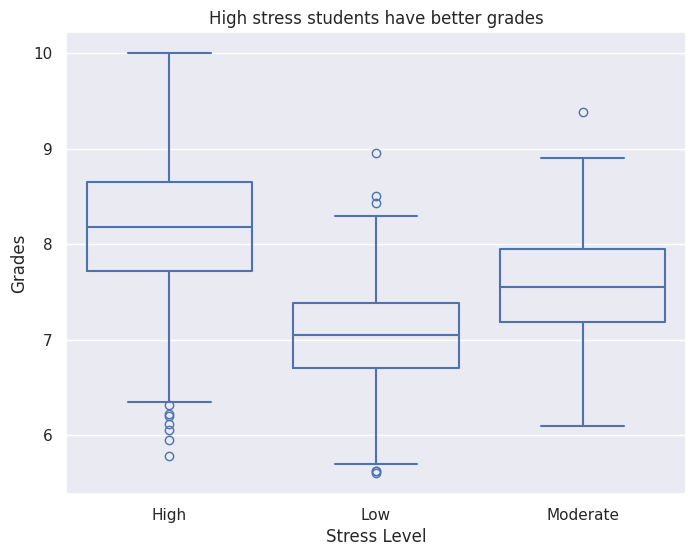

In [109]:
# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x=STRESS, y=GRADES, fill=False)

# Labeling
plt.title("High stress students have better grades")
plt.xlabel("Stress Level")
plt.ylabel("Grades")
plt.show()

# Differences in variables between stress levels

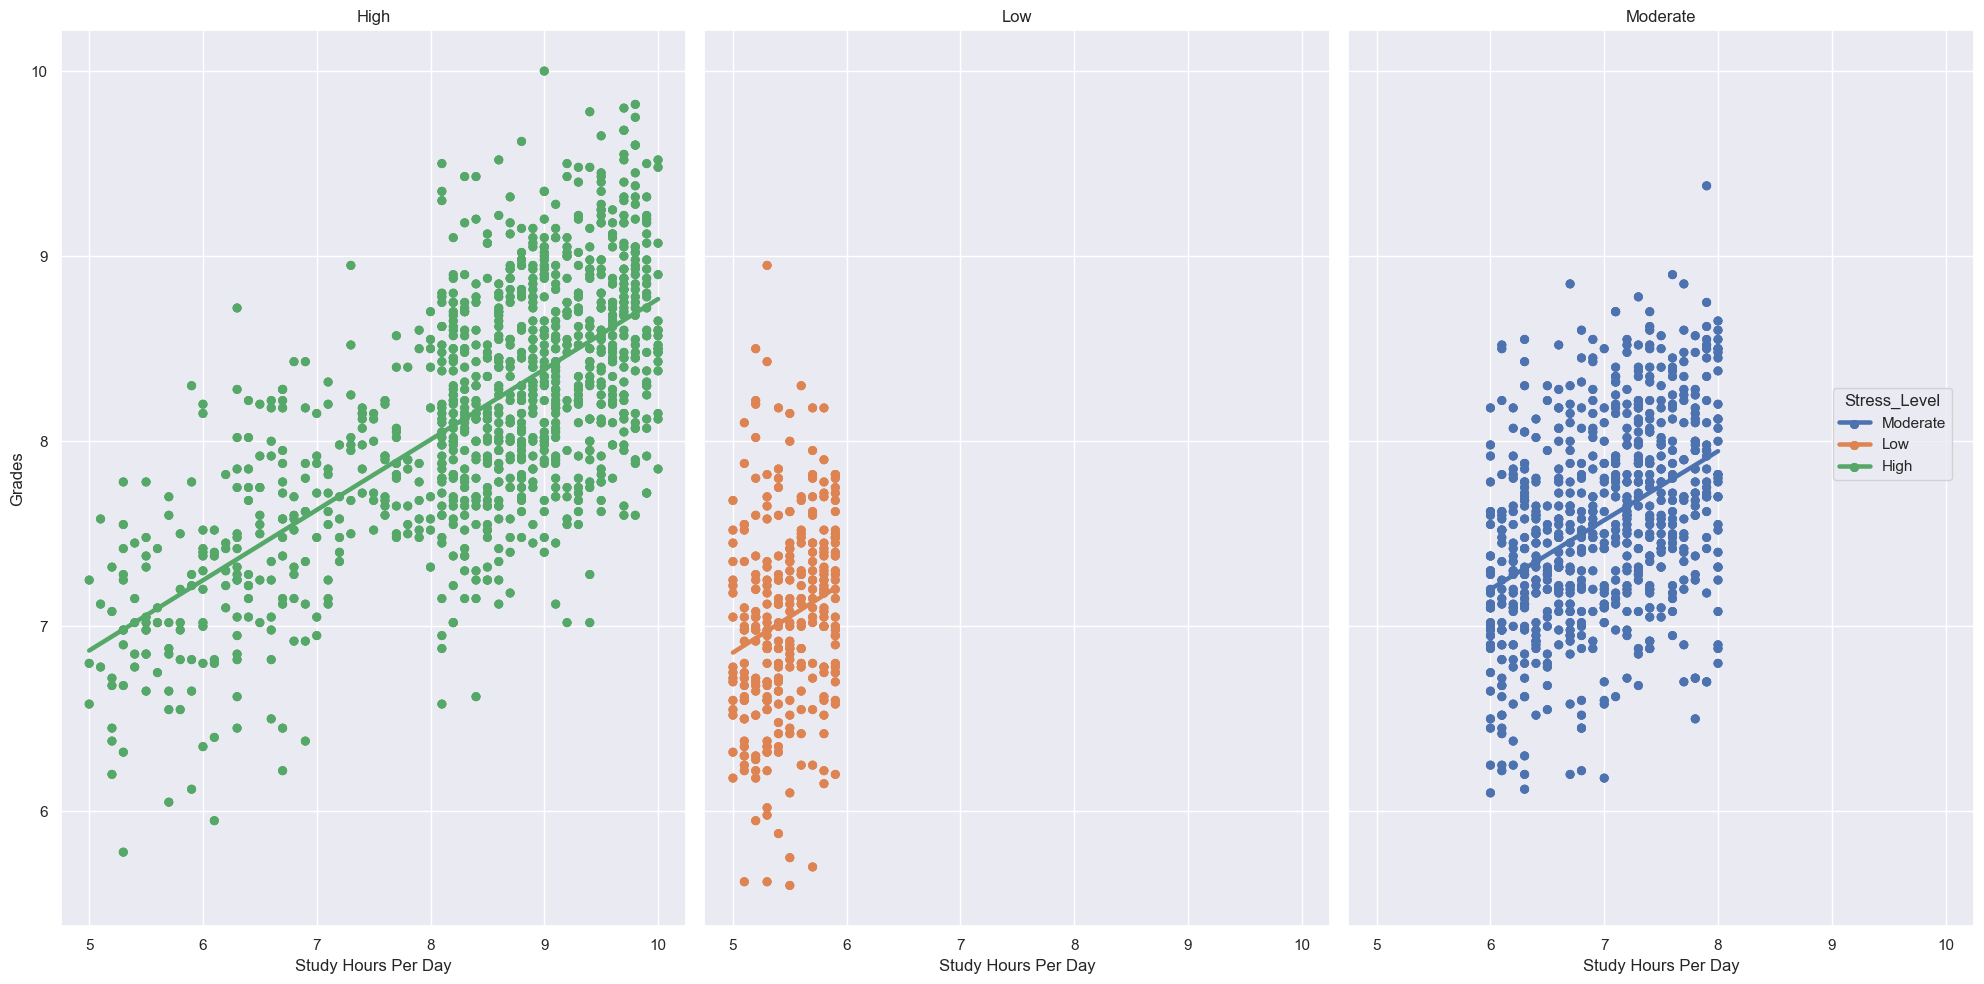

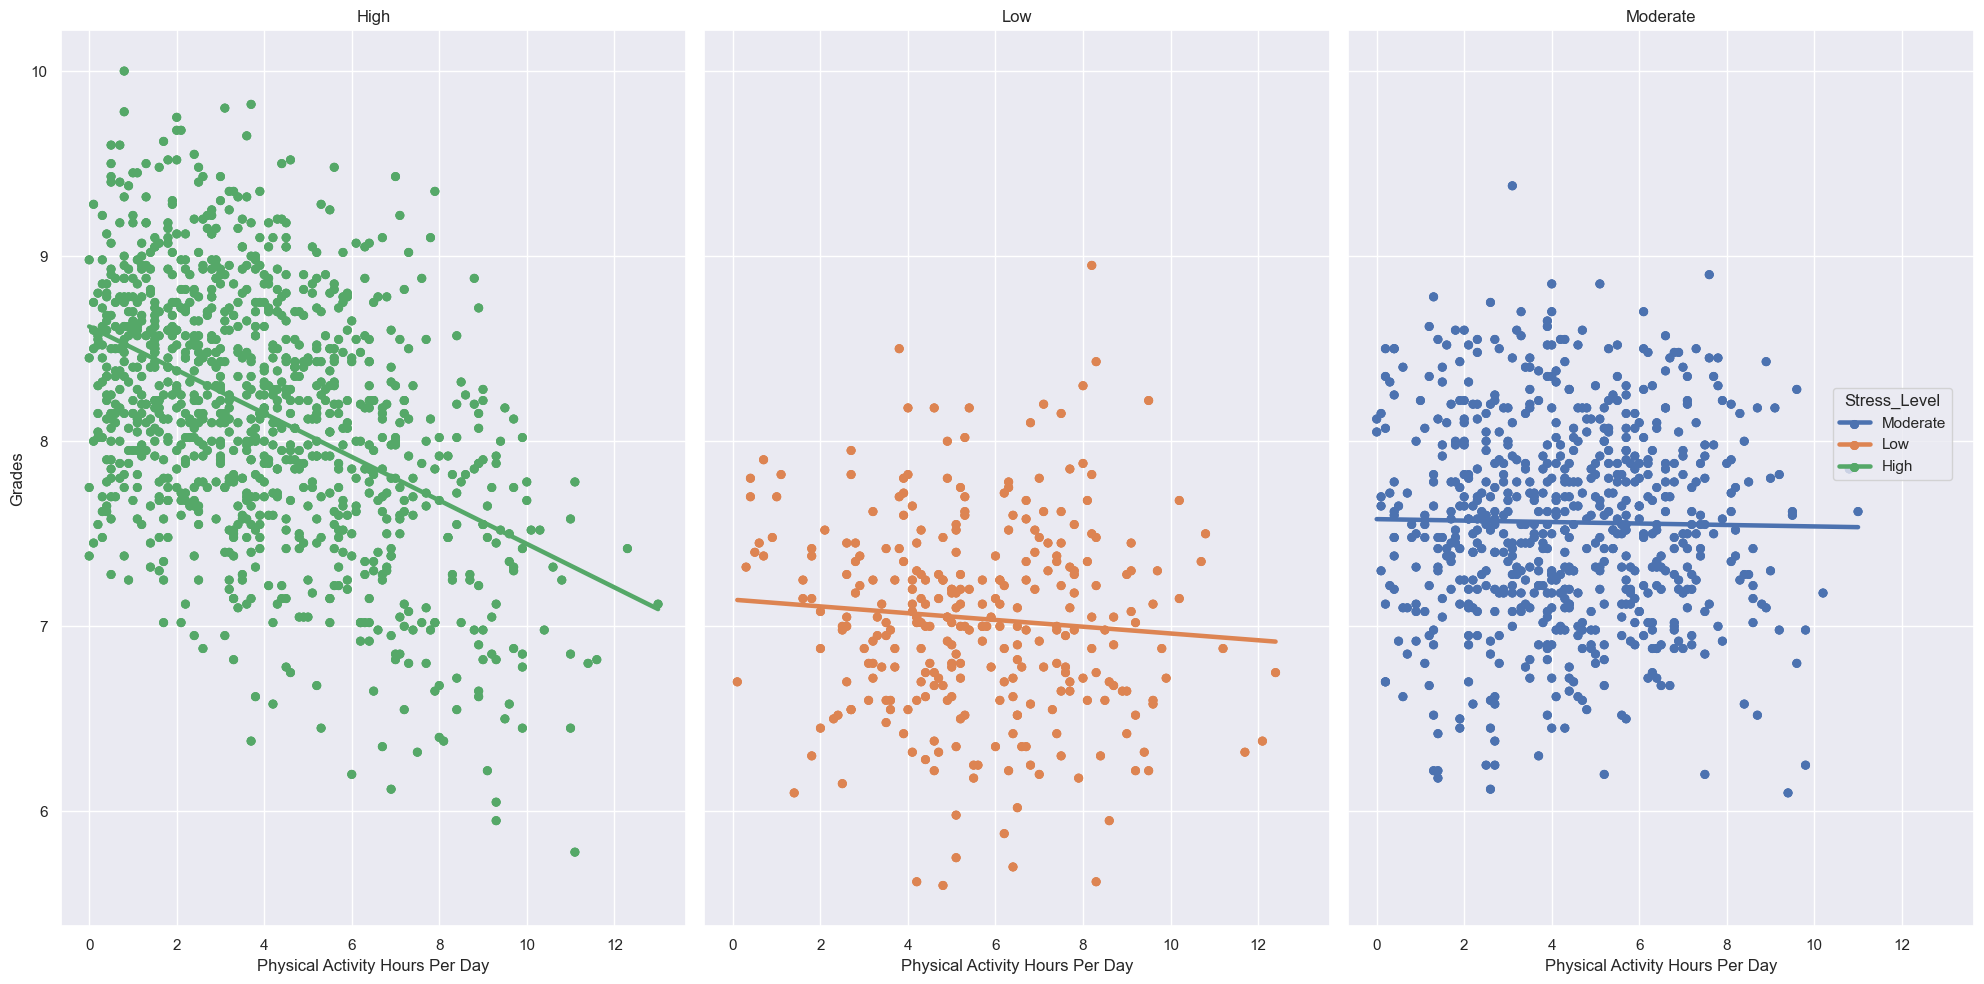

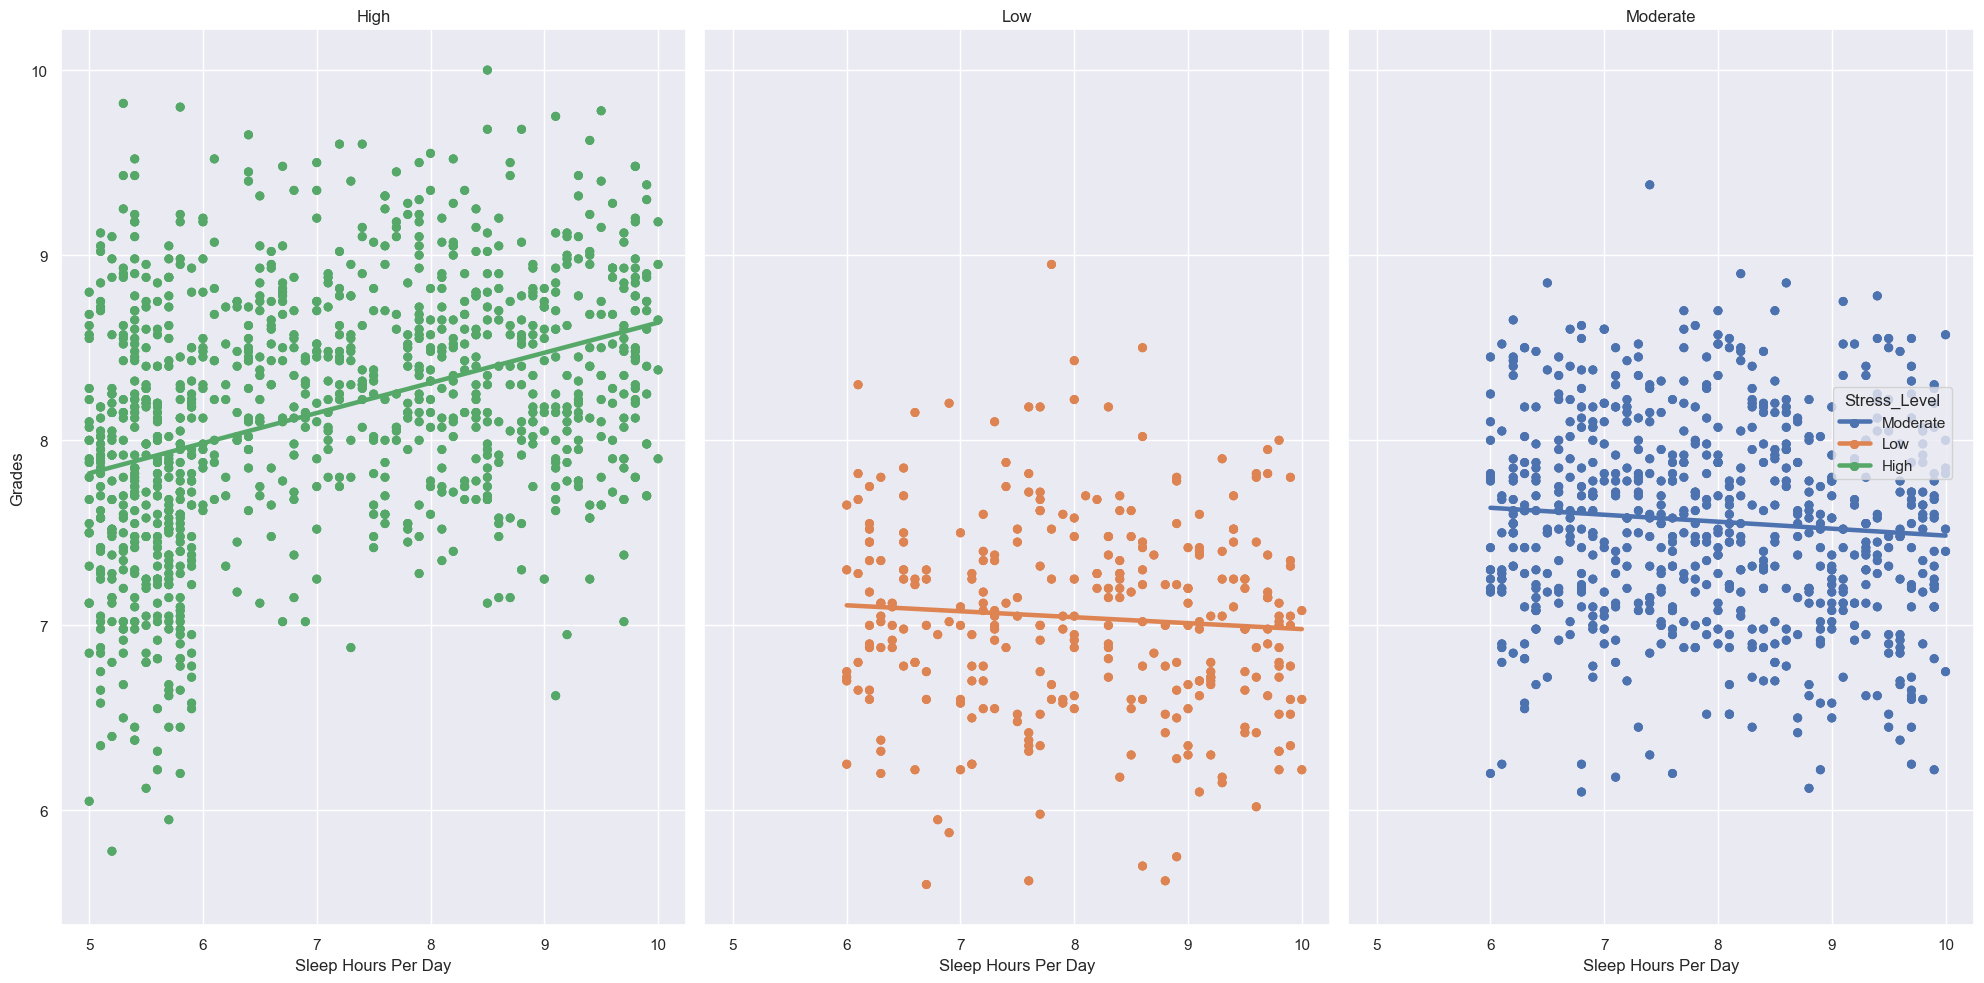

In [113]:
for x_axis, y_axis in [(STUDY, GRADES), (PHYSICAL, GRADES), (SLEEP, GRADES)]:
  (
    so.Plot(data=df, x=x_axis, y=GRADES, color=STRESS)
    .add(so.Dot())
    .add(so.Line(linewidth=3.25), so.PolyFit(order=1))
    .facet(col=STRESS)
    .layout(size=(20,10))
    .label(
        x=humanize_column(x_axis),
        y=humanize_column(y_axis)
    )
    .add(so.Dot())
    .show()
  )

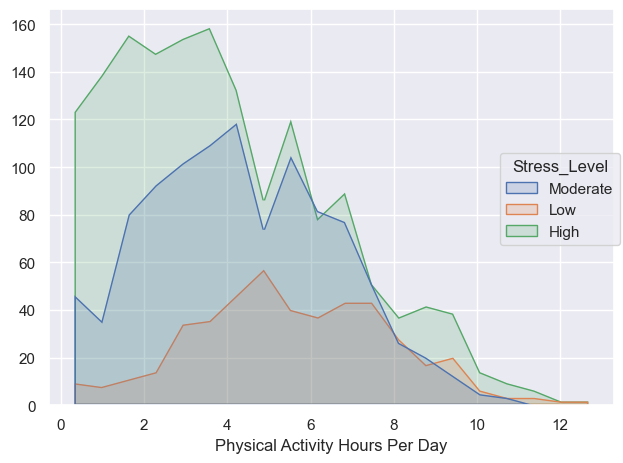

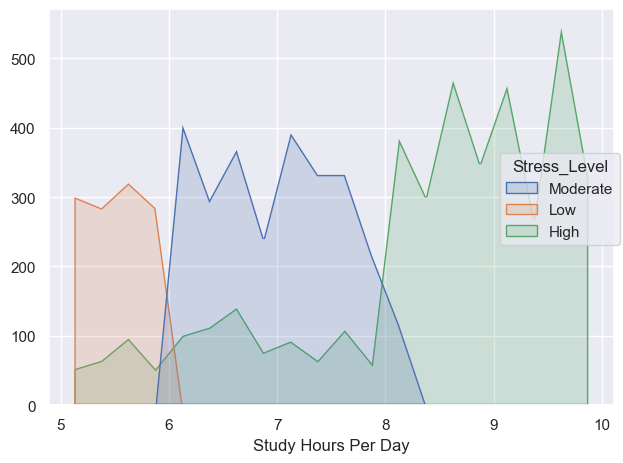

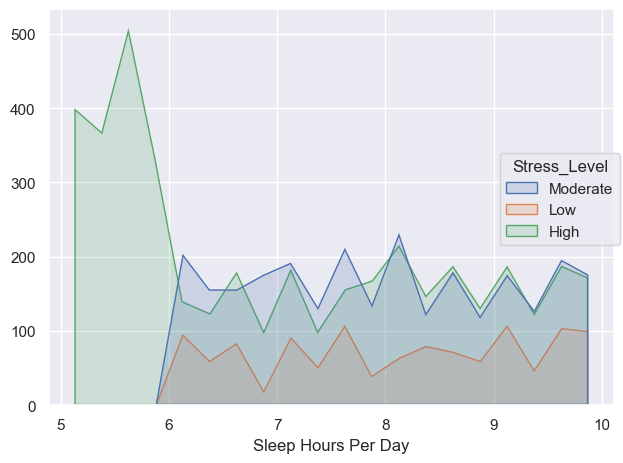

In [106]:
for variable in [PHYSICAL, STUDY, SLEEP]:
    (
        so.Plot(data=df, x=variable, color=STRESS)
        .add(so.Area(), so.Hist(stat="frequency", bins=20))
        .label(x=humanize_column(variable))
        .show()
    )

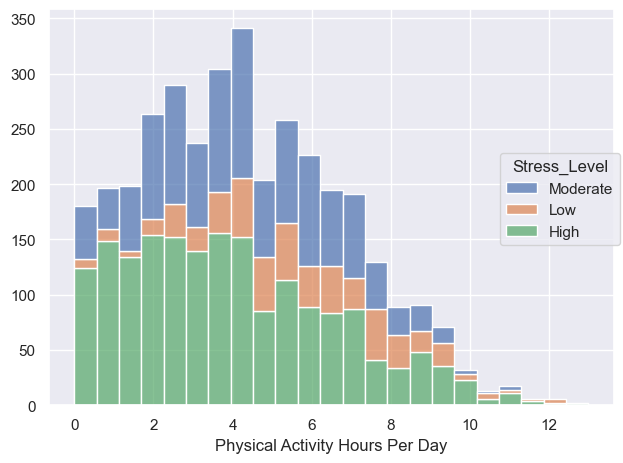

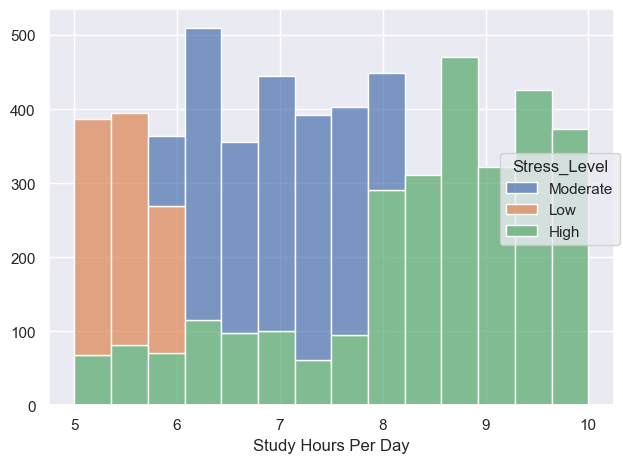

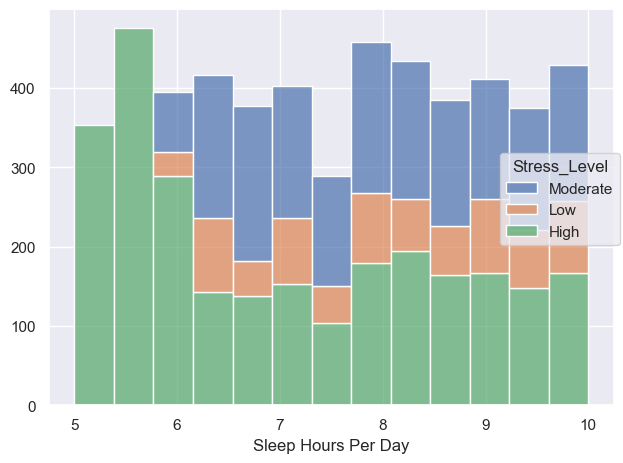

In [107]:
for variable in [PHYSICAL, STUDY, SLEEP]:
    (
        so.Plot(df, x=variable, color=STRESS)
        .add(so.Bars(), so.Hist(stat="frequency", common_norm=False), so.Stack())
        .label(x=humanize_column(variable))
        .show()
    )

# High Stress Students and Sleep

/var/folders/k6/43ddyt252z727pfv61y_p_mh0000gr/T/ipykernel_90215/2514969048.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_stress_df["Sleep Group"] = high_stress_df[SLEEP].apply(lambda x: "<6 hrs" if x < 6 else "6+ hrs")


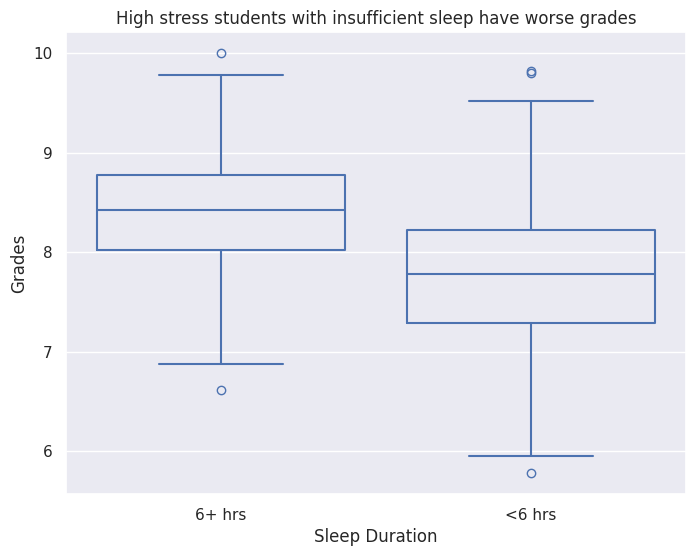

In [108]:
# Filter for high stress students
high_stress_df = df[df[STRESS] == "High"]

# Create a new sleep group column
high_stress_df["Sleep Group"] = high_stress_df[SLEEP].apply(lambda x: "<6 hrs" if x < 6 else "6+ hrs")

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=high_stress_df, x="Sleep Group", y=GRADES, fill=False)

# Labeling
plt.title("High stress students with insufficient sleep have worse grades")
plt.xlabel("Sleep Duration")
plt.ylabel("Grades")
plt.show()

# Writeup
## Findings
* Sleep hours do not in fact have a correlation with grades if other factors are not taken into account
* Study hours have a correlation (spearman `0.74`) with grades
* If the data is divided between the 3 stress levels, then there was a positive correlation with the high stress group between sleep and grades (spearman `0.49`); high stress students with less than 6 hours of sleep have worse grades than other high stress students

## Further questions
* What do the grades mean?
* How do the high stress students have consistently better grades? (Ask Dr. P-S)